In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string, os 
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.4.1


In [3]:
batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 50000

In [4]:
# reading dataset
df = pd.read_csv('../input/chatbot-dataset-topical-chat/topical_chat.csv')
df.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [5]:
# basic preprocessing
def process(text):
    text = text.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '') \
          .replace('"', ' ').replace(".", " ").replace("!", " ").replace("?", " ").replace(";", " ").replace(":", " ")

    text = "".join(v for v in text if v not in string.punctuation).lower()
    #text = text.encode("utf8").decode("ascii",'ignore')

    text = " ".join(text.split())
    #text+="<eos>"
    return text


In [6]:
df.message = df.message.apply(process)

In [7]:
df.head()

,conversation_id,message,sentiment
0,1,are you a fan of google or microsoft,Curious to dive deeper
1,1,both are excellent technology they are helpful...,Curious to dive deeper
2,1,im not a huge fan of google but i use it a lot...,Curious to dive deeper
3,1,google provides online related services and pr...,Curious to dive deeper
4,1,yeah their services are good im just not a fan...,Curious to dive deeper


In [8]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words_set = set()
target_words_set = set()

for conversation_index in tqdm(range(df.shape[0])):
    
    if conversation_index == 0:
        continue
        
    input_text = df.iloc[conversation_index - 1]
    target_text = df.iloc[conversation_index]
    
    if input_text.conversation_id == target_text.conversation_id:
        
        input_text = input_text.message
        target_text = target_text.message
        
        if len(input_text.split()) > 2 and \
            len(target_text.split()) > 0 and \
            len(input_text.split()) < 30 and \
            len(target_text.split()) < 10 and \
            input_text and \
            target_text:
            
            target_text = "bos " + target_text + " eos"
                
            input_texts.append(input_text)
            target_texts.append(target_text)
            
            for word in input_text.split():
                if word not in input_words_set:
                    input_words_set.add(word)
            for word in target_text.split():
                if word not in target_words_set:
                    target_words_set.add(word)

100%|██████████| 188378/188378 [01:23<00:00, 2244.23it/s]


In [9]:
input_words = sorted(list(input_words_set))
target_words = sorted(list(target_words_set))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(txt.split()) for txt in input_texts])
max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i) for i, word in enumerate(target_words)])

#saving
with open('input_token_index.pickle', 'wb') as handle:
    pickle.dump(input_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#saving
with open('target_token_index.pickle', 'wb') as handle:
    pickle.dump(target_token_index, handle, protocol=pickle.HIGHEST_PROTOCOL)


encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    
    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.0

Number of samples: 20190
Number of unique input tokens: 12272
Number of unique output tokens: 7485
Max sequence length for inputs: 29
Max sequence length for outputs: 11


In [10]:
embedding_size = 100

# seq2seq model - https://keras.io/examples/nlp/lstm_seq2seq/
with strategy.scope():
    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None,))
    
    encoder_embedding_output = keras.layers.Embedding(num_encoder_tokens, embedding_size)(encoder_inputs)
                                               
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_embedding_output)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None,))
    
    decoder_embedding = keras.layers.Embedding(num_decoder_tokens, embedding_size)
    decoder_embedding_output = decoder_embedding(decoder_inputs)
    

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    1227200     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    748500      input_2[0][0]                    
______________________________________________________________________________________________

In [11]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=20,
    validation_split=0.1,
)

Epoch 1/20
284/284 [==============================] - 29s 79ms/step - loss: 4.2122 - accuracy: 0.1085 - val_loss: 3.8888 - val_accuracy: 0.1148
Epoch 2/20
284/284 [==============================] - 19s 69ms/step - loss: 3.7445 - accuracy: 0.1195 - val_loss: 3.7955 - val_accuracy: 0.1236
Epoch 3/20
284/284 [==============================] - 19s 68ms/step - loss: 3.6225 - accuracy: 0.1300 - val_loss: 3.6998 - val_accuracy: 0.1358
Epoch 4/20
284/284 [==============================] - 20s 69ms/step - loss: 3.4956 - accuracy: 0.1425 - val_loss: 3.5775 - val_accuracy: 0.1541
Epoch 5/20
284/284 [==============================] - 19s 68ms/step - loss: 3.3715 - accuracy: 0.1589 - val_loss: 3.5158 - val_accuracy: 0.1596
Epoch 6/20
284/284 [==============================] - 20s 69ms/step - loss: 3.2700 - accuracy: 0.1705 - val_loss: 3.4535 - val_accuracy: 0.1725
Epoch 7/20
284/284 [==============================] - 20s 69ms/step - loss: 3.1933 - accuracy: 0.1784 - val_loss: 3.4085 - val_accuracy:

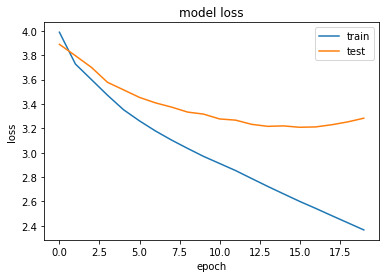

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
# Save model
model.save("s2s.hdf5")

In [14]:
# define the encoder model 
encoder_model = keras.Model(encoder_inputs, encoder_states)
encoder_model.summary()

decoder_state_input_h = keras.Input(shape=(None,))
decoder_state_input_c = keras.Input(shape=(None,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_output = decoder_embedding(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding_output, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)
# Reverse-lookup token index to decode sequences back 
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1227200   
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1255424   
Total params: 2,482,624
Trainable params: 2,482,624
Non-trainable params: 0
_________________________________________________________________


In [15]:
encoder_model.save("encoder_model.hdf5")
decoder_model.save("decoder_model.hdf5")

In [16]:
def respond(text):
    input_seq = np.zeros(
        (1, max_encoder_seq_length), dtype="float32"
    )
    
    for t, word in enumerate(text.split()):
        input_seq[0, t] = input_token_index[word]
        
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['bos']
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'eos' or
           len(decoded_sentence) > 50):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_char
            
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value = [h, c]
    return decoded_sentence

In [17]:
respond("how are you")

' im doing great how about you'

In [18]:
respond("good morning")

' im doing great how about you'

In [19]:
respond("good bye")

' bye'

In [20]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    decoded_sentence = respond(input_texts[seq_index])
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: yes google is the biggest search engine and google service figure out top 100 website including youtube and blogger
Decoded sentence:  that is true do you like the simpsons
-
Input sentence: yes he even won a hardcore cha cha championship in 1958
Decoded sentence:  yeah do you know who invented the simpsons
-
Input sentence: true did you know jackson had a patent on a dancing device
Decoded sentence:  i wonder how that is that is that
-
Input sentence: yes it helped him smooth out his dance moves
Decoded sentence:  that is true do you like to
-
Input sentence: i wonder if they met how that would go from there
Decoded sentence:  yeah do you know who is it
-
Input sentence: oh yeah i didnt know that either i also want to go to google plex to see the goats who mow their lawn by eating it
Decoded sentence:  i agree do you like the simpsons
-
Input sentence: hi do you like to dance
Decoded sentence:  i do like the simpsons
-
Input sentence: dancing is a lot of fun did you 

In [21]:
eos_token = target_token_index['eos']
eos_token

2367

In [22]:
from math import log
def generate_beam_text(seed_text, next_words, beam_search_n, break_at_eos):
    
    distributions_scores_states = [[list(), 0.0, [None, None]]]
    
    decoder_states_value = None
    
    for _ in range(next_words):
        
        sequence_temp_candidates = list()
        
        for i in range(len(distributions_scores_states)): 
            
            input_seq = np.zeros(
                (1, max_encoder_seq_length), dtype="float32"
            )
            
            # Generate empty target sequence of length 1.
            target_seq = np.zeros((1,1))
            
            seq, score, states_values = distributions_scores_states[i]
            
            if len(distributions_scores_states) == 1:
                for t, word in enumerate(process(seed_text).split()):
                    input_seq[0, t] = input_token_index[word]
                
                # Encode the input as state vectors.
                decoder_states_value = encoder_model.predict(input_seq)
                
                # Populate the first character of target sequence with the start character.
                target_seq[0, 0] = target_token_index['bos']
                
            else:
                target_seq[0, 0] = seq[-1]
                decoder_states_value = states_values
                
                candidate_sentence = ""
                for token_index in seq:
                    if token_index == eos_token:
                        break
                        
                    word = reverse_target_char_index[token_index]
                    candidate_sentence+=word + " "
                
                print("score :", score, " | ", candidate_sentence)
            
            
            output_tokens_distribution, h, c = decoder_model.predict([target_seq] + decoder_states_value)
            
            # Update states
            decoder_states_value = [h, c]

            predicted_distribution = output_tokens_distribution[0][0]
            
            for j in range(len(predicted_distribution)):
                if predicted_distribution[j] > 0:
                    candidate = [seq + [j], score - log(predicted_distribution[j]), decoder_states_value]
                    if break_at_eos and j == eos_token:
                        continue
                    else:
                        sequence_temp_candidates.append(candidate)

        
        # 2. score and sort all candidates
        ordered = sorted(sequence_temp_candidates, key=lambda tup:tup[1])
        
        distributions_scores_states = ordered[:beam_search_n]
          
        print("-----")


In [23]:
generate_beam_text("i wonder if they met how that would go from there", 5, 5, False)

-----
score : 1.508763374648386  |  yeah 
score : 2.300557150569393  |  i 
score : 2.722317758640162  |  yes 
score : 3.1788073380596176  |  thats 
score : 3.239766224844746  |  that 
-----
score : 3.0749155085018067  |  yeah do 
score : 3.635949544669585  |  that is 
score : 4.153193165356847  |  yeah it 
score : 4.181916516769293  |  i wonder 
score : 4.2536417320853825  |  yeah did 
-----
score : 3.082756643449847  |  yeah do you 
score : 4.319386933931611  |  yeah did you 
score : 4.80027326558378  |  yeah it was 
score : 5.4698747423512595  |  i wonder if 
score : 5.561435009076355  |  that is a 
-----
score : 3.855469520224067  |  yeah do you know 
score : 4.44540486420173  |  yeah do you like 
score : 5.15764814941168  |  yeah did you know 
score : 5.249811273073151  |  yeah did you ever 
score : 5.966278879033659  |  yeah do you listen 
-----


In [24]:
generate_beam_text("do you like comic books", 4, 5, False)

-----
score : 0.6923293816944258  |  i 
score : 1.7951278810092168  |  yes 
score : 2.5549163675296684  |  hello 
score : 3.076988190827499  |  hi 
score : 3.4503708156687045  |  no 
-----
score : 1.7784087598247964  |  i do 
score : 2.2440612155839346  |  i love 
score : 2.2472715145797  |  yes i 
score : 2.9221924466814833  |  i am 
score : 3.3952805422411156  |  hello i 
-----
score : 3.223500757115688  |  i do like 
score : 3.5311024281654237  |  yes i love 
score : 3.5903981162668344  |  yes i do 
score : 3.9675193287741655  |  i do do 
score : 4.005788316589965  |  i do not 
-----


In [25]:
generate_beam_text("thanks", 5, 5, False)

-----
score : 1.7102533650594378  |  have 
score : 1.7118555216243436  |  you 
score : 2.328844675879099  |  thanks 
score : 3.1592126918586683  |  same 
score : 3.1686122547974658  |  good 
-----
score : 1.821844011993711  |  have a 
score : 2.1114886353258004  |  you too 
score : 3.364815084312946  |  you as 
score : 3.4689299083235925  |  thanks 
score : 3.702053709354673  |  thanks you 
-----
score : 2.336939836421376  |  have a good 
score : 2.455030583826675  |  you too 
score : 3.3327284266831114  |  have a great 
score : 3.559883090899644  |  you as well 
score : 4.876384816966427  |  thanks you 
-----
score : 3.175420771274927  |  have a good day 
score : 3.860761856899029  |  have a great day 
score : 3.8740029184516396  |  you as well 
score : 4.21619233912346  |  have a good one 
score : 4.613287070278759  |  have a good night 
-----


In [26]:
generate_beam_text("hi do you like to dance", 5, 5, False)

-----
score : 0.6967029514232902  |  i 
score : 2.058328723317083  |  yes 
score : 2.3854770252110087  |  hello 
score : 2.973131143488388  |  hi 
score : 3.1969852540288826  |  im 
-----
score : 1.8577302773662696  |  i do 
score : 2.1974824432530173  |  i love 
score : 2.5369583358750436  |  yes i 
score : 2.663272202514004  |  i am 
score : 3.214885945392991  |  hello i 
-----
score : 3.473527080311821  |  i do like 
score : 3.7176748035168794  |  yes i love 
score : 3.8828897931598765  |  i do do 
score : 4.018547636007732  |  yes i do 
score : 4.246595135131729  |  i am a 
-----
score : 3.892527788427893  |  i do do you 
score : 5.497044016645958  |  yes i do do 
score : 5.660947931904751  |  yes i love the 
score : 5.675961980351319  |  i do like the 
score : 5.792850907830006  |  yes i do like 
-----
